In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

import sys
sys.path.append("src")  # hacky way to get access to the util.save_perf
from util import save_perf

In [2]:
adata_sc = ad.read_h5ad("data/adata_rosmap_v3_top959.h5ad")
adata_sc_val = ad.read_h5ad("data/seaad959_k30_matched.h5ad")

In [13]:
SAMPLE_COL = "Donor ID"
LABEL = "Label"
LABEL_VAL = "Wang"

TOTAL_COUNTS_COL = "total_counts"
TOTAL_COUNTS_COL_VAL = "Number of UMIs"

In [5]:
adata_sc = adata_sc[adata_sc.obs["Label"].isin(["AD", "CT"])].copy()
adata_sc.obs["y"] = adata_sc.obs["Label"].map({"AD": 1, "CT": 0})

In [6]:
adata_sc_val = adata_sc_val[adata_sc_val.obs[LABEL_VAL].isin(["AD", "Healthy"])].copy()
adata_sc_val.obs["y"] = adata_sc_val.obs[LABEL_VAL].map({"AD": 1, "Healthy": 0})

In [14]:
DONORS = sorted(adata_sc.obs[SAMPLE_COL].unique())

x = np.zeros((len(DONORS), adata_sc.shape[1]))

for i, donor in enumerate(tqdm(DONORS)):
    adata_donor = adata_sc[adata_sc.obs[SAMPLE_COL] == donor]

    donor_x = adata_donor.X.todense()

    # undo log transformation
    donor_x = np.expm1(donor_x)

    # inflate cells to original counts
    for j in range(donor_x.shape[0]):
        donor_xj_sum = donor_x[j].sum()
        if donor_xj_sum > 0:
            donor_x[j] = donor_x[j] * adata_donor.obs[TOTAL_COUNTS_COL].values[j] / donor_xj_sum
        else:
            donor_x[j] = 0
            print(f"Warning: all zero counts for cell {j} of donor {donor}.")

    # aggregate all cells of this donor to simulate bulk
    x[i] = donor_x.sum(axis=0) 

adata = ad.AnnData(x, obs=adata_sc.obs[adata_sc.obs["Donor ID"].isin(DONORS)].groupby(SAMPLE_COL, observed=True).first(), var=adata_sc.var)
adata.obs["Donor ID"] = DONORS

100%|██████████| 330/330 [00:49<00:00,  6.63it/s]
c:\Users\timo\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
# same for validation data
DONORS_VAL = sorted(adata_sc_val.obs[SAMPLE_COL].unique())

x = np.zeros((len(DONORS_VAL), adata_sc_val.shape[1]))

for i, donor in enumerate(tqdm(DONORS_VAL)):
    adata_donor = adata_sc_val[adata_sc_val.obs[SAMPLE_COL] == donor]

    donor_x = adata_donor.X.todense()

    # undo log transformation
    donor_x = np.expm1(donor_x)

    # inflate cells to original counts
    for j in range(donor_x.shape[0]):
        donor_xj_sum = donor_x[j].sum()
        if donor_xj_sum > 0:
            donor_x[j] = donor_x[j] * adata_donor.obs[TOTAL_COUNTS_COL_VAL].values[j] / donor_xj_sum
        else:
            donor_x[j] = 0
            print(f"Warning: all zero counts for cell {j} of donor {donor}.")

    # aggregate all cells of this donor to simulate bulk
    x[i] = donor_x.sum(axis=0) 

adata_val = ad.AnnData(x, obs=adata_sc_val.obs[adata_sc_val.obs["Donor ID"].isin(DONORS_VAL)].groupby(SAMPLE_COL, observed=True).first(), var=adata_sc_val.var)
adata_val.obs["Donor ID"] = DONORS_VAL

100%|██████████| 40/40 [00:16<00:00,  2.49it/s]


In [28]:
X = adata.X
Y = adata.obs["y"].values

X = X / X.sum(axis=1).reshape(-1, 1) * 1e4
# X = np.log1p(X)
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [29]:
X_val = adata_val.X
Y_val = adata_val.obs["y"].values

X_val = X_val / X_val.sum(axis=1).reshape(-1, 1) * 1e4
# X_val = np.log1p(X_val)
X_val = (X_val - X_val.mean(axis=0)) / X_val.std(axis=0)

<Axes: >

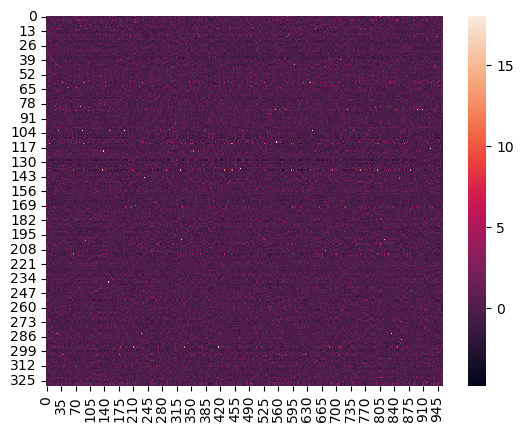

In [19]:
sns.heatmap(X)

In [ ]:
# put them both in a UMAP

from sklearn.decomposition import PCA
from umap import UMAP

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)
X_val_pca = pca.transform(X_val)

x_cat = np.concatenate([X_pca, X_val_pca], axis=0)
set_cat = np.concatenate([np.zeros(X_pca.shape[0]), np.ones(X_val_pca.shape[0])], axis=0)

umap = UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
x_umap = umap.fit_transform(x_cat)


C:\Users\timo\AppData\Local\Temp\ipykernel_31936\3570186313.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x_umap[set_cat == 0, 0], y=x_umap[set_cat == 0, 1], palette=["blue", "orange"], alpha=0.5, label="ROSMAP")
C:\Users\timo\AppData\Local\Temp\ipykernel_31936\3570186313.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x_umap[set_cat == 1, 0], y=x_umap[set_cat == 1, 1], palette=["blue", "orange"], alpha=0.5, label="SeaAD")


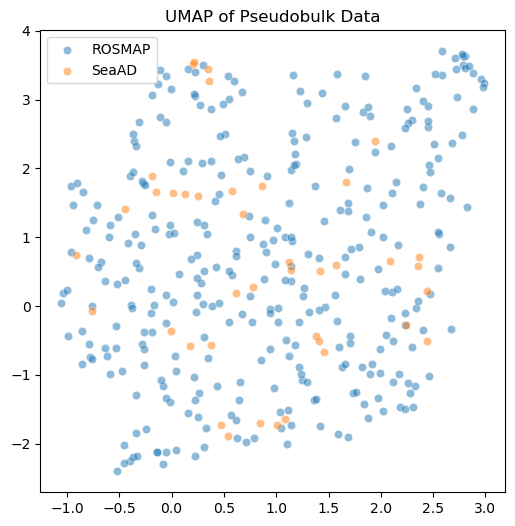

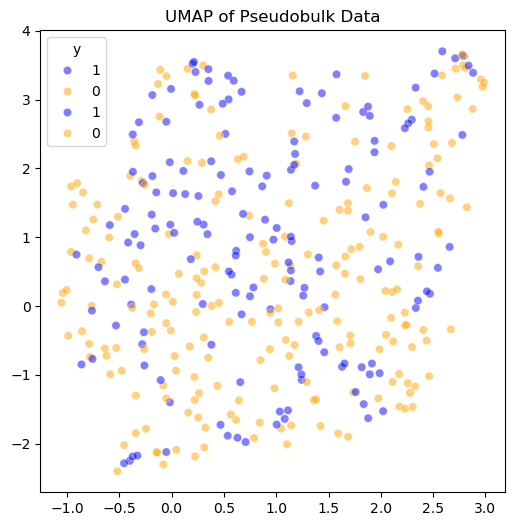

In [26]:

plt.figure(figsize=(6, 6))
sns.scatterplot(x=x_umap[set_cat == 0, 0], y=x_umap[set_cat == 0, 1], palette=["blue", "orange"], alpha=0.5, label="ROSMAP")
sns.scatterplot(x=x_umap[set_cat == 1, 0], y=x_umap[set_cat == 1, 1], palette=["blue", "orange"], alpha=0.5, label="SeaAD")
plt.title("UMAP of Pseudobulk Data")
plt.show()

# one more, color by label
plt.figure(figsize=(6, 6))
sns.scatterplot(x=x_umap[set_cat == 0, 0], y=x_umap[set_cat == 0, 1], palette=["blue", "orange"], alpha=0.5, hue=adata.obs["y"])
sns.scatterplot(x=x_umap[set_cat == 1, 0], y=x_umap[set_cat == 1, 1], palette=["blue", "orange"], alpha=0.5, hue=adata_val.obs["y"])
plt.title("UMAP of Pseudobulk Data")
plt.show()



In [61]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

X_train = X
Y_train = Y
X_test = X_val
Y_test = Y_val

model = Lasso(alpha=0.05)
model.fit(X_train, Y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_pred_train_soft = y_pred_train.copy()
y_pred_test_soft = y_pred_test.copy()

train_auc = roc_auc_score(Y_train, y_pred_train)
test_auc = roc_auc_score(Y_test, y_pred_test)

y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = (y_pred_test > 0.5).astype(int)

train_acc = accuracy_score(Y_train, y_pred_train)
test_acc = accuracy_score(Y_test, y_pred_test)
train_prec = precision_score(Y_train, y_pred_train)
test_prec = precision_score(Y_test, y_pred_test)
train_rec = recall_score(Y_train, y_pred_train)
test_rec = recall_score(Y_test, y_pred_test)
train_f1 = f1_score(Y_train, y_pred_train)
test_f1 = f1_score(Y_test, y_pred_test)

save_perf(
    exp_name="SeaAD",
    model_name="Pseudobulk",
    fold=0,
    accuracy=test_acc,
    precision=test_prec,
    recall=test_rec,
    f1=test_f1,
    roc_auc=test_auc,
    train_accuracy=train_acc,
    train_precision=train_prec,
    train_recall=train_rec,
    train_f1=train_f1,
    train_roc_auc=train_auc,
    train_donors=DONORS,
    test_donors=DONORS_VAL,
    train_y=np.array(Y_train),
    test_y=np.array(Y_test),
    train_y_pred=y_pred_train_soft.flatten(),
    test_y_pred=y_pred_test_soft.flatten(),
    processing="cpm, z-score (no log)",
)

print(f"TRAIN: Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
print(f"TEST:  Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

TRAIN: Acc: 0.7303, Prec: 0.7778, Rec: 0.3952, F1: 0.5241, AUC: 0.8130
TEST:  Acc: 0.3000, Prec: 1.0000, Rec: 0.1515, F1: 0.2632, AUC: 0.8182


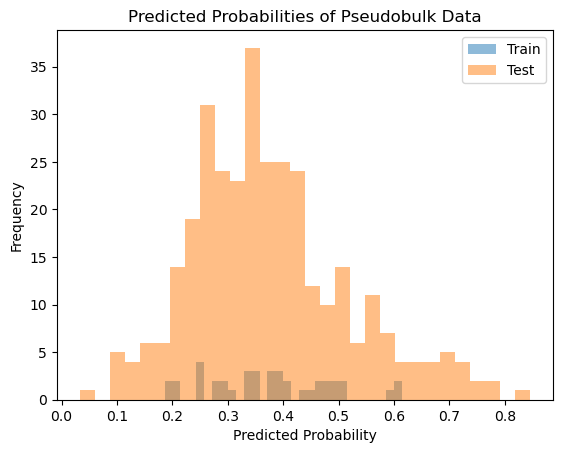

In [60]:
plt.hist(y_pred_test_soft, bins=30, alpha=0.5, label="Train")
plt.hist(y_pred_train_soft, bins=30, alpha=0.5, label="Test")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Predicted Probabilities of Pseudobulk Data")
plt.legend()
plt.show()